# Setup



In [1]:
!python --version

Python 3.10.14


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:0000:01


In [3]:
import os
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
seed = 42
torch.manual_seed(seed)
print(f"torch version: {torch.__version__}")

torch version: 2.4.0


# Dataset

For details about the dataset see `data_handling.ipynb`

In [4]:
SAVE_FOLDER = "/kaggle/input/tdk-v2"
SEQ_LEN = 128
data_file_path = os.path.join(SAVE_FOLDER, f"data_{SEQ_LEN}.pkl")
meta_file_path = os.path.join(SAVE_FOLDER, f"metadata_{SEQ_LEN}.csv")

df = pd.read_pickle(data_file_path)
df = df[[f"{coord}_dominant_hand_{i}" for i in range(21) for coord in ["x", "y", "z"]]] # NOTE tensor.reshape(21, 3) should give the correct representation
df.head()

,x_dominant_hand_0,y_dominant_hand_0,z_dominant_hand_0,x_dominant_hand_1,y_dominant_hand_1,z_dominant_hand_1,x_dominant_hand_2,y_dominant_hand_2,z_dominant_hand_2,x_dominant_hand_3,...,z_dominant_hand_17,x_dominant_hand_18,y_dominant_hand_18,z_dominant_hand_18,x_dominant_hand_19,y_dominant_hand_19,z_dominant_hand_19,x_dominant_hand_20,y_dominant_hand_20,z_dominant_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0.408832,0.828362,0.000001,0.519912,0.797813,-0.065295,0.612159,0.729445,-0.099489,0.707576,...,-0.152852,0.302987,0.730378,-0.257519,0.372977,0.770165,-0.275822,0.413130,0.798621,-0.266876
1816796431,0.398663,0.805901,0.000002,0.523662,0.796239,-0.082688,0.638807,0.744409,-0.143600,0.744236,...,-0.203126,0.351343,0.722034,-0.315719,0.406092,0.768912,-0.326104,0.442418,0.799930,-0.314282
1816796431,0.419290,0.815355,0.000002,0.509726,0.797622,-0.070057,0.593165,0.742897,-0.119156,0.685492,...,-0.181363,0.345995,0.714686,-0.286298,0.435894,0.734443,-0.316182,0.506857,0.748464,-0.322671
1816796431,0.398764,0.810161,0.000002,0.498118,0.775277,-0.051467,0.583356,0.725558,-0.102596,0.677779,...,-0.170996,0.331533,0.676444,-0.240285,0.383946,0.659086,-0.266193,0.434939,0.642554,-0.278110
1816796431,0.420213,0.793506,0.000001,0.495650,0.769774,-0.048765,0.571790,0.718986,-0.088109,0.659049,...,-0.131329,0.344246,0.631696,-0.183113,0.369611,0.592241,-0.208774,0.403788,0.562679,-0.225284


In [5]:
metadata_df = pd.read_csv(meta_file_path, header=0)

max_phrase_len = max([len(it) for it in metadata_df.phrase.values])
possible_characters = sorted(set.union(*[set(p) for p in metadata_df.phrase.values]))
token_map = {c: i+3 for i, c in enumerate(possible_characters)}
PADDING = 'P'
SOS = '<'
EOS = '>'
token_map[PADDING] = 0 # padding
token_map[SOS] = 1 # SOS
token_map[EOS] = 2 # EOS
metadata_df.phrase = metadata_df.phrase.apply(lambda it: np.array([token_map[c] for c in '<'+it+'>'+('P'*(max_phrase_len-len(it)))], dtype=np.int32))
max_phrase_len_with_sequence_control_tokens = max_phrase_len + 2 # SOS, EOS

# Shuffle dataset
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

index = {row[0]: {"phrase": row[1], "signer_id": row[2]} for row in metadata_df.to_numpy()}
str(index)[:100] + "..."

"{250063096: {'phrase': array([ 1,  9,  4,  9,  6,  3, 16, 31, 14, 27, 32, 33, 28, 27, 18,  2,  0,\n  ..."

In [64]:
def preprocess_features(flat_xyz: np.ndarray):
    if len(flat_xyz.shape) == 1:
        flat_xyz = np.array([flat_xyz])

    batch_dim = flat_xyz.shape[0]
    xyz = flat_xyz.reshape((batch_dim, 21, 3))

    # Take only the x and y coordinates, as z only shows relative distance
    xy = xyz[:, :, :2]

    # Center the points to (0,0)
    centroids = xy.mean(axis=1, keepdims=True)
    centered_xy = xy - centroids

    # Calculate the max distance in x and y directions separately
    max_x_distances = np.max(np.abs(centered_xy[..., 0]), axis=1, keepdims=True)  # shape: (batch_dim, 1)
    max_y_distances = np.max(np.abs(centered_xy[..., 1]), axis=1, keepdims=True)  # shape: (batch_dim, 1)
    
    # Calculate separate scale factors for x and y directions
    scale_factors_x = 1 / max_x_distances  # shape: (batch_dim, 1)
    scale_factors_y = 1 #/ max_y_distances  # shape: (batch_dim, 1)

    # Scale x and y coordinates separately
    scaled_x = centered_xy[..., 0] * scale_factors_x  # shape: (batch_dim, 21)
    scaled_y = centered_xy[..., 1] * scale_factors_y  # shape: (batch_dim, 21)

    # Combine the scaled x and y coordinates
    scaled_xy = np.stack([scaled_x, scaled_y], axis=-1)  # shape: (batch_dim, 21, 2)

    # Concatenate back the z-coordinates (without scaling) to retain depth info
    xyz = np.concatenate([scaled_xy, xyz[:, :, 2:]], axis=2)
    return xyz.reshape((batch_dim, -1))

# Example usage
preprocessed_xyz = preprocess_features(df.values[:2].astype(np.float32))
preprocessed_xyz

array([[-1.10539779e-01,  1.71225548e-01,  1.43825059e-06,
         2.07000628e-01,  1.40677094e-01, -6.52954429e-02,
         4.70706761e-01,  7.23091364e-02, -9.94892642e-02,
         7.43470728e-01,  3.67641449e-02, -1.34329841e-01,
         1.00000000e+00,  2.02807784e-02, -1.69375926e-01,
         1.34954184e-01, -1.47425532e-02, -9.35534909e-02,
         2.43893564e-01, -1.00800574e-01, -1.57288164e-01,
         3.03179234e-01, -1.55493140e-01, -1.93132892e-01,
         3.39378685e-01, -2.04150796e-01, -2.17872515e-01,
        -1.60956189e-01, -9.05579329e-03, -1.09474696e-01,
        -2.88544387e-01, -1.04457736e-01, -1.96916208e-01,
        -3.37618023e-01, -1.66521549e-01, -2.45855495e-01,
        -3.92338932e-01, -2.18071818e-01, -2.69147664e-01,
        -4.11718786e-01,  2.30115652e-02, -1.29743367e-01,
        -3.28335077e-01, -1.20016336e-02, -2.51500934e-01,
        -1.13580145e-01,  3.99152040e-02, -2.78686613e-01,
         1.50176175e-02,  8.21138620e-02, -2.66529560e-0

In [68]:
class TransformerDataset(torch.utils.data.Dataset):
    def __init__(self, df, meta_data, normalize=False):
        self.df = df
        self.meta_data = meta_data
        self.sequence_ids = df.index.unique()
        self.padding_value = 0.0
        self.seq_len = SEQ_LEN
        self.normalize = normalize

    def __len__(self):
        return len(self.sequence_ids)

    def __getitem__(self, idx):
        sequence_id = self.sequence_ids[idx]
        x_values = self.df.loc[sequence_id].values
        x_values = preprocess_features(x_values)
        x_values = torch.tensor(x_values, dtype=torch.float32) # (num_frames, 63)
        
        # Normalization across both time and hand axis
#         if self.normalize:
#             x_values = x_values.reshape(-1, 21, 3)
#             mean_vals = x_values.mean(axis=(0,))  # Shape: (3,) representing avg_x, avg_y, avg_z
#             std_vals = x_values.std(axis=(0, 1))    # Shape: (3,) representing std_x, std_y, std_z
#             x_values = (x_values - mean_vals) / std_vals
#             x_values = x_values.reshape(-1, 63)

        x_mask = torch.ones(self.seq_len, dtype=torch.float32)

        # Apply padding if the sequence is shorter than seq_len
        if x_values.shape[0] < self.seq_len:
            x_mask[x_values.shape[0]:] = token_map[PADDING]
            padding_size = self.seq_len - x_values.shape[0]
            padding = torch.full((padding_size, x_values.shape[1]), self.padding_value)
            x_values = torch.cat([x_values, padding], dim=0)
        elif x_values.shape[0] > self.seq_len:
            # Truncate the sequence if it's longer than seq_len
            x_values = x_values[:self.seq_len]

        y_phrase = self.meta_data[sequence_id]['phrase']
        return x_values, x_mask, y_phrase

dataset = TransformerDataset(df, index)

In [69]:
dataset.__getitem__(0)[0]

tensor([[-1.1054e-01,  1.7123e-01,  1.4383e-06,  ..., -9.8255e-02,
          1.4148e-01, -2.6688e-01],
        [-2.8355e-01,  1.3295e-01,  1.6993e-06,  ..., -1.5412e-01,
          1.2698e-01, -3.1428e-01],
        [-1.9310e-01,  1.5566e-01,  1.6338e-06,  ...,  9.8229e-02,
          8.8769e-02, -3.2267e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

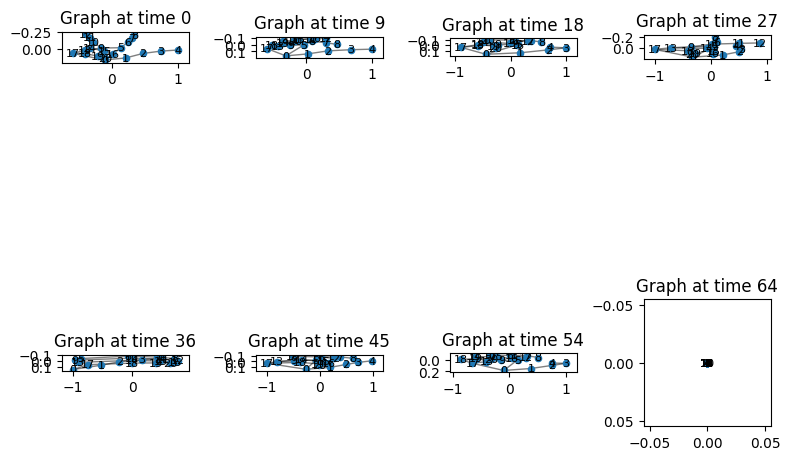

In [70]:
import networkx as nx

# Visualize hands

# Create the edge list and make it undirected by adding reverse connections (same for all graphs)
connections = [
    (0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
    (5,6), (5,9), (6,7), (7,8), (9,10), (9,13), 
    (10,11), (11,12), (13,14), (13,17), (14,15), 
    (15,16), (17,18), (18,19), (19,20)
]
edges = []
for a, b in connections:
    edges.append([a, b])
    edges.append([b, a])  # Add the reverse connection
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Format data
node_features = dataset.__getitem__(0)[0].reshape(SEQ_LEN, 21, 3)

# Get the number of graphs to sample
num_graphs = 8

# Sample indices at equal distances
seq_len = node_features.shape[0]
sample_indices = np.linspace(0, seq_len/2, num_graphs, dtype=int)

# Draw plots
fig, axs = plt.subplots(2, 4, figsize=(8, 8))
axs = axs.flatten()  # Flatten to easily iterate over axes

for i, idx in enumerate(sample_indices):
    x = node_features[idx, :, 0]
    y = node_features[idx, :, 1]

    G = nx.Graph()
    G.add_edges_from([(int(u.item()), int(v.item())) for u, v in edge_index.T])

    pos = {int(j): (float(x[j]), float(y[j])) for j in range(len(x))}

    # Plot the graph on the corresponding axis
    nx.draw_networkx_nodes(G, pos, node_size=20, ax=axs[i])
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=axs[i])
    nx.draw_networkx_labels(G, pos, font_size=8, ax=axs[i])

    # Invert the y-axis and set equal aspect ratio
    axs[i].invert_yaxis()
    axs[i].set_aspect('equal', adjustable='box')
    
    # Disable tick labels for a cleaner display
    axs[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    # Add labels and title for each subplot
    axs[i].set_title(f"Graph at time {idx}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [44]:
from torch.utils.data import random_split, DataLoader

BATCH_SIZE = 32

# Split lengths for train (80%), test (10%), valid (10%)
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# NOTE Keep num_workers=0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

for it in train_loader:
    print("Shape of x:")
    print(it[0].shape)
    print("\nMask for input:")
    print(it[1].shape)
    print(it[1])
    print("\nTarget:")
    print(it[2].shape)
    print(it[2]) # NOTE dec inp: it[1][:, :-1], target: it[1][:, 1:]
    break

Shape of x:
torch.Size([32, 128, 63])

Mask for input:
torch.Size([32, 128])
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

Target:
torch.Size([32, 33])
tensor([[ 1, 13,  7,  ...,  0,  0,  0],
        [ 1, 12, 12,  ...,  0,  0,  0],
        [ 1, 23, 34,  ...,  0,  0,  0],
        ...,
        [ 1,  8, 13,  ...,  0,  0,  0],
        [ 1,  6,  8,  ...,  0,  0,  0],
        [ 1, 32, 22,  ...,  0,  0,  0]], dtype=torch.int32)


In [12]:
iterator = iter(train_loader)
%timeit next(iterator)

35.9 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Constructing the Transformer

Sources:

- [correct `transformer implementation` from scratch in `pytorch`](https://towardsdatascience.com/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb) (in-depth tutorial from same author: [part1](https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021), [part2](https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-2-bf2403804ada))
- [nice visuals for understanding `multi-head attention`](http://jalammar.github.io/illustrated-transformer/)
- [`positional encoding`](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/)
- [kaggle transformer code: ❗Contains mistakes (see comments), but nice overall explanation](https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch)

## General Components

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len, n=10000):
        super(PositionalEncoding, self).__init__()

        assert d_model % 2 == 0, "d_model must be even"
        
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(n) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # NOTE
        # register buffer in Pytorch ->
        # If you have parameters in your model, which should be saved and restored in the state_dict,
        # but not trained by the optimizer, you should register them as buffers.
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # Broadcasting mechanism (automatically works for multiple batches even when shapes don't match along batch dim)
        return x + self.pe[:, :x.size(1)]

In [15]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

## Encoder Embeddings

In [16]:
class LandmarkEmbedding(nn.Module):
    def __init__(self, d_model, num_features, num_conv_layers, filter_size):
        super(LandmarkEmbedding, self).__init__()

        self.d_model = d_model

        first_conv = nn.Conv1d(in_channels=num_features, out_channels=d_model, kernel_size=filter_size, padding='same')
        rest_of_convs = [
            nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=filter_size, padding='same')
            for _ in range(num_conv_layers-1)
        ]
        
        self.conv_block = nn.Sequential(
            first_conv, *rest_of_convs
        )

    def forward(self, x):
        # x is expected to be of shape (batch_size, seq_len, num_of_features)
        x = x.permute(0, 2, 1) # (batch_size, num_of_features, seq_len)
        x = self.conv_block(x)
        # TODO experiment with scaling the output
        # x *= math.sqrt(self.d_model)
        x = x.permute(0, 2, 1) # (batch_size, seq_len, d_model)
        return x

In [17]:
lm_embedding = LandmarkEmbedding(
    d_model=128,
    num_features=21*3, #num_nodes_per_hands*num_features_per_node
    num_conv_layers=3,
    filter_size=11
)

# Check parameter tensor shapes
for name, param in lm_embedding.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()}")

# Measure Performance
x = next(iter(train_loader))[0]
%timeit lm_embedding(x)

Layer: conv_block.0.weight | Size: torch.Size([128, 63, 11])
Layer: conv_block.0.bias | Size: torch.Size([128])
Layer: conv_block.1.weight | Size: torch.Size([128, 128, 11])
Layer: conv_block.1.bias | Size: torch.Size([128])
Layer: conv_block.2.weight | Size: torch.Size([128, 128, 11])
Layer: conv_block.2.bias | Size: torch.Size([128])
16 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
from typing import Literal

from torch_geometric.data import Data, Batch
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

class MyGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyGCNConv, self).__init__()
        
        self.conv = GCNConv(in_channels, out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.relu(x)
        return x
    
class MyGATConv(nn.Module):
    def __init__(self, in_channels, out_channels, attention_heads):
        super(MyGATConv, self).__init__()
        
        assert out_channels % attention_heads == 0
        
        self.conv = GATConv(in_channels, out_channels//attention_heads, heads=attention_heads, concat=True)
        self.combine_heads = nn.Linear(out_channels, out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.combine_heads(x)
        x = self.relu(x)
        return x
    
class MyGATv2Conv(MyGATConv):
    def __init__(self, in_channels, out_channels, attention_heads):
        super(MyGATv2Conv, self).__init__(in_channels, out_channels, attention_heads)
        
        # Replace the GATConv layer with GATv2Conv
        self.conv = GATv2Conv(in_channels, out_channels // attention_heads, heads=attention_heads, concat=True)
        

class GraphEmbedding(nn.Module):
    def __init__(
            self,
            num_nodes: int,
            num_features_per_node: int,
            d_model: int,
            hidden_dim: int,
            seq_len: int,
            batch_size: int,
            layer_type: Literal["gcn_conv", "gat_conv", "gat_conv_v2"],
            num_layers: int,
            attention_heads = None
        ):
        super(GraphEmbedding, self).__init__()
        self.d_model = d_model
        self.num_nodes = num_nodes
        self.num_features_per_node = num_features_per_node
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        assert num_layers >= 2
        
        if attention_heads:
            assert hidden_dim % attention_heads == 0 and d_model % attention_heads == 0

        if layer_type == "gcn_conv":
            conv_layers = []
            conv_layers.append(MyGCNConv(num_features_per_node, hidden_dim))
            for i in range(1, num_layers):
                conv_layers.append(MyGCNConv(hidden_dim, hidden_dim if i != num_layers-1 else d_model))
            self.graph_conv = nn.ModuleList(conv_layers)
        else:
            conv_layers = []
            conv_layer_class = MyGATConv if layer_type == "gat_conv" else MyGATv2Conv
            conv_layers.append(conv_layer_class(num_features_per_node, hidden_dim, attention_heads))
            for i in range(1, num_layers):
                conv_layers.append(conv_layer_class(hidden_dim, hidden_dim if i != num_layers-1 else d_model, attention_heads))
            self.graph_conv = nn.ModuleList(conv_layers)

        # Precompute edge_index and batch_info for batch
        # Based on: https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/loader/dataloader.py
        connections = [
            (0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
            (5,6), (5,9), (6,7), (7,8), (9,10), (9,13),
            (10,11), (11,12), (13,14), (13,17), (14,15),
            (15,16), (17,18), (18,19), (19,20)
        ]
        edges = []
        for a, b in connections:
            edges.append([a, b])
            edges.append([b, a])  # Add the reverse connection
        single_graph_edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        # NOTE Edge index calculation can be done without using Batch.from_data_list(...) -> improve performance
        # For a one time run this is good enough.
        example_graph_features = torch.zeros(self.num_nodes, self.num_features_per_node)
        data_list = [Data(x=example_graph_features, edge_index=single_graph_edge_index) for _ in range(self.batch_size*self.seq_len)]
        mini_batch = Batch.from_data_list(data_list)

        # This prevents prevents this layer to work with different batch sizes (TODO fix)
        self.register_buffer('edge_index', mini_batch.edge_index)
        self.register_buffer('batch_info', mini_batch.batch)

    def forward(self, x):
        # x ~ (batch_size, seq_len, num_features)
        
        x = x.reshape(-1, self.num_features_per_node) # (batch_size*seq_len*num_nodes, num_features_per_node)
        
        # Obtain node embeddings
        for layer in self.graph_conv:
            x = layer(x, self.edge_index)
        
        # Readout layer
        x = global_mean_pool(x, self.batch_info)  # (batch_size*sequence_len, d_model)
        
        x = x.reshape(self.batch_size, self.seq_len, self.d_model)
        return x

In [19]:
graph_embedding = GraphEmbedding(
    num_nodes=21,
    num_features_per_node=3,
    d_model=128,
    hidden_dim=128,
    seq_len=SEQ_LEN,
    batch_size=BATCH_SIZE,
    layer_type="gcn_conv",
    num_layers=3,
    attention_heads=8
)

# Check parameter tensor shapes
for name, param in graph_embedding.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()}")

# Measure Performance
x = next(iter(train_loader))[0]

# NOTE This is slower than LandmarkEmbedding
# ?!Rewrite GNN layers using the fact that all graphs will have the same structure

# Run on GPU to make it faster
x = x.to("cuda")
graph_embedding.to("cuda")

%timeit graph_embedding(x)

Layer: graph_conv.0.conv.bias | Size: torch.Size([128])
Layer: graph_conv.0.conv.lin.weight | Size: torch.Size([128, 3])
Layer: graph_conv.1.conv.bias | Size: torch.Size([128])
Layer: graph_conv.1.conv.lin.weight | Size: torch.Size([128, 128])
Layer: graph_conv.2.conv.bias | Size: torch.Size([128])
Layer: graph_conv.2.conv.lin.weight | Size: torch.Size([128, 128])
12.8 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Rest of the Transformer

In [20]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.masked_self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.masked_self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [22]:
class Transformer(nn.Module):
    def __init__(
            self,
            encoder_embedding: nn.Module,
            tgt_vocab_size: int,
            d_model: int,
            num_heads: int,
            num_enc_layers: int,
            num_dec_layers: int,
            d_ff: int,
            max_seq_length: int,
            dropout: float
        ):
        super(Transformer, self).__init__()

        self.encoder_embedding = encoder_embedding
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_enc_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_dec_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src_mask, tgt):
        src_mask = (src_mask != 0).unsqueeze(1).unsqueeze(2) # NOTE Here the src_mask contains ones and zeros
        tgt_mask = (tgt != token_map[PADDING]).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(tgt_mask.device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, x_mask, tgt):
        src_mask, tgt_mask = self.generate_mask(x_mask, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

# Training Utils

In [23]:
# Source: https://github.com/jamfromouterspace/levenshtein

def levenshtein_distance(seq1, seq2):
    len_1, len_2 = len(seq1), len(seq2)
    dp = [[0] * (len_2 + 1) for _ in range(len_1 + 1)]

    for i in range(len_1 + 1):
        dp[i][0] = i
    for j in range(len_2 + 1):
        dp[0][j] = j

    for i in range(1, len_1 + 1):
        for j in range(1, len_2 + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,
                           dp[i][j - 1] + 1,
                           dp[i - 1][j - 1] + cost)

    return dp[len_1][len_2]

indices_to_ignore = torch.tensor([token_map[" "], token_map["<"], token_map["P"]]) # End of sequence is important

def masked_levenshtein(output_tokens, target_tokens):
    batch_size = output_tokens.size(0)
    total_distance = 0

    for i in range(batch_size):
        pred_seq = output_tokens[i].tolist()
        target_seq = target_tokens[i].tolist()

        # Find first occurrence of EOS in both sequences
        pred_eos_idx = next((idx for idx, token in enumerate(pred_seq) if token == token_map[EOS]), len(pred_seq))
        target_eos_idx = next((idx for idx, token in enumerate(target_seq) if token == token_map[EOS]), len(target_seq))

        # Trim the sequences at the first EOS index
        pred_trimmed = pred_seq[:pred_eos_idx]
        target_trimmed = target_seq[:target_eos_idx]

        # Compute Levenshtein distance for the trimmed sequences
        total_distance += levenshtein_distance(pred_trimmed, target_trimmed)

    # NOTE not sum of distances are returned!
    return total_distance


In [24]:
# # Optional lr scheduling as in Attention Is All You Need
# class LinearWarmupInverseSquarerootDecay(torch.optim.lr_scheduler.LambdaLR):
#     def __init__(self, d_model, warmup_steps=4000, optimizer=None):
#         self.d_model = d_model
#         self.warmup_steps = warmup_steps
#         super(LinearWarmupInverseSquarerootDecay, self).__init__(optimizer, self.lr_lambda)

#     def lr_lambda(self, step_num):
#         return (self.d_model ** -0.5) * min(step_num ** -0.5 if step_num != 0 else 1e20, step_num * (self.warmup_steps ** -1.5))
    
# steps = np.arange(0, 10000)
# learning_rates = [scheduler.lr_lambda(step) for step in steps]

# plt.figure(figsize=(6, 3))
# plt.plot(steps, learning_rates, label='Learning Rate')
# plt.title('Learning Rate Schedule')
# plt.xlabel('Step Number')
# plt.ylabel('Learning Rate')
# plt.grid(True)
# plt.legend()
# plt.show()

# scheduler = LinearWarmupInverseSquarerootDecay(d_model=d_model, optimizer=optimizer)

# Training

In [39]:
import os
import json
import zipfile
import time

def eval_settings(settings: dict):
    # Create model
    encoder_embedding = LandmarkEmbedding(
        d_model=settings["d_model"],
        num_features=settings["num_nodes_per_hand"]*settings["num_features_per_node"],
        num_conv_layers=settings["embedding"]["num_conv_layers"],
        filter_size=settings["embedding"]["filter_size"]
    ) if settings["embedding"]["name"] == "landmark_embedding" else GraphEmbedding(
        num_nodes=settings["num_nodes_per_hand"],
        num_features_per_node=settings["num_features_per_node"],
        d_model=settings["d_model"],
        hidden_dim=settings["embedding"]["hidden_dim"],
        seq_len=settings["seq_len"],
        batch_size=settings["batch_size"],
        layer_type=settings["embedding"]["layer_type"],
        num_layers=settings["embedding"]["num_layers"],
        attention_heads=settings["embedding"].get("attention_heads")
    )

    transformer = Transformer(
        encoder_embedding=encoder_embedding,
        tgt_vocab_size = settings["tgt_vocab_size"],
        d_model=settings["d_model"],
        num_heads=settings["num_heads"],
        num_enc_layers=settings["num_enc_layer"],
        num_dec_layers=settings["num_dec_layer"],
        d_ff=settings["dff"],
        max_seq_length=max(settings["phrase_length"], settings["seq_len"]),
        dropout=settings["dropout"]
    )
    
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformer.to(device)
    
    # Run training
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignoring padding
    optimizer = torch.optim.Adam(transformer.parameters())
    #optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0)
    
    # Helper
    def run_epoch(loader, is_train=True):
        epoch_loss = 0
        total_correct = 0
        total_tokens = 0
        total_levenshtein_distance = 0

        if is_train:
            transformer.train()
        else:
            transformer.eval()

        for batch in loader:
            src_data, x_mask, tgt_data = batch
            src_data = src_data.to(device)
            x_mask = x_mask.to(device)
            tgt_data = tgt_data.to(device)

            optimizer.zero_grad()

            # Disable gradient calculation during validation
            with torch.set_grad_enabled(is_train):
                output = transformer(src_data, x_mask, tgt_data[:, :-1])
                loss = criterion(output.contiguous().view(-1, settings["tgt_vocab_size"]), 
                                 tgt_data[:, 1:].contiguous().view(-1).long())

                if is_train:
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()

            # Calculate masked accuracy
            output_tokens = output.argmax(dim=-1)  # Shape: (batch_size, seq_len)
            non_pad_mask = tgt_data[:, 1:] != settings["padding_token"]  # Ignore padding tokens (mask for target data)
            correct = (output_tokens == tgt_data[:, 1:]) & non_pad_mask  # Compare predictions to targets and ignore padding
            total_correct += correct.sum().item()
            total_tokens += non_pad_mask.sum().item()

            # Calculate masked Levenshtein distance
            total_levenshtein_distance += masked_levenshtein(output_tokens, tgt_data[:, 1:])

        avg_loss = epoch_loss / len(loader)
        accuracy = total_correct / total_tokens
        return avg_loss, accuracy, total_levenshtein_distance/(settings["batch_size"]*len(loader))

    training_metrics = []
    for epoch in range(settings["epochs"]):
        start_time = time.time()
        
        train_loss, train_accuracy, train_levenshtein = run_epoch(train_loader, is_train=True)
        valid_loss, valid_accuracy, valid_levenshtein = run_epoch(valid_loader, is_train=False)
        
        epoch_duration = time.time() - start_time

        display_text = f"Epoch {epoch+1}"
        display_text += f" | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Levenshtein: {train_levenshtein:.4f}"
        display_text += f" | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid Levenshtein: {valid_levenshtein:.4f}"
        display_text += f" | Epoch Time: {epoch_duration:.2f} seconds"
        print(display_text)

        training_metrics.append([epoch+1, train_loss, train_accuracy, train_levenshtein, valid_loss, valid_accuracy, valid_levenshtein])
        
    # Eval on test dataset
    test_loss, test_accuracy, test_levenshtein = run_epoch(test_loader, is_train=False)
    width = 34
    print("\n" + "=" * width)
    print(" Evaluation Results ")
    print("=" * width)
    print(f" Test Loss: {test_loss:.4f}")
    print(f" Test Accuracy: {100*test_accuracy:.2f}%")
    print(f" Test Levenshtein Distance: {test_levenshtein:.2f}")
    print("=" * width)
    
    # Save results
    
    output_folder = settings['config_name']
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ## Save settings
    settings_path = os.path.join(output_folder, "settings.json")
    with open(settings_path, "w") as settings_file:
        settings_file.write(json.dumps(settings, indent=4))

    ## Save test results
    test_results_path = os.path.join(output_folder, "test_results.json")
    with open(test_results_path, "w") as test_results_file:
        test_results_file.write(json.dumps({
            "loss": test_loss,
            "accuracy": test_accuracy,
            "edit_dist": test_levenshtein
        }))

    ## Save model
    model_path = os.path.join(output_folder, 'model.pth')
    torch.save(transformer.state_dict(), model_path)

    ## Save training metrics
    training_metrics_path = os.path.join(output_folder, "training_metrics.csv")
    training_metrics_df = pd.DataFrame(
        training_metrics,
        columns=['epoch', 'train_loss', 'train_accuracy', 'train_levenshtein', 'valid_loss', 'valid_accuracy', 'valid_levenshtein']
    )
    training_metrics_df.to_csv(training_metrics_path, index=False)
    

In [34]:
import uuid
import copy

setting_variations = []
for MODEL_NAME, MODEL_SIZE in zip(["hybrid"], [256]):
    global_settings = {
        # Data
        "d_model": MODEL_SIZE,
        "seq_len": SEQ_LEN,
        "padding_token": token_map[PADDING],

        # Training
        "batch_size": BATCH_SIZE,
        "epochs": 40,

        # Transformer
        "num_nodes_per_hand": 21,
        "num_features_per_node": 3,
        "tgt_vocab_size": len(token_map),
        "num_heads": 2,
        "num_enc_layer": 2,
        "num_dec_layer": 4,
        "dff": MODEL_SIZE,
        "dropout": 0.1,
        "phrase_length": max_phrase_len_with_sequence_control_tokens,
    }

    embedding_settings = [
        {
            "embedding": {
                "name": "graph_embedding",
                "layer_type": "gcn_conv",
                "num_layers": 2,
                "attention_heads": 2,
                "hidden_dim": MODEL_SIZE,
            }
        },
        {
            "embedding": {
                "name": "graph_embedding",
                "layer_type": "gat_conv",
                "num_layers": 2,
                "attention_heads": 2,
                "hidden_dim": MODEL_SIZE,
            }
        },
        {
            "embedding": {
                "name": "graph_embedding",
                "layer_type": "gat_conv_v2",
                "num_layers": 2,
                "attention_heads": 2,
                "hidden_dim": MODEL_SIZE,
            }
        },
        {
            "embedding": {
                "name": "landmark_embedding",
                "num_conv_layers": 3,
                "filter_size": 11,
            }
        }
    ]
    
    for embed_setting in embedding_settings:
        global_settings.update(embed_setting)
        embed_name = "landmark_embedding" if global_settings["embedding"]["name"] == "landmark_embedding" else global_settings["embedding"]["layer_type"]
        global_settings["config_name"] = f"{MODEL_NAME}-{embed_name}"
        setting_variations.append(copy.deepcopy(global_settings))

In [41]:
[f'{it["config_name"]} - {it["epochs"]}' for it in setting_variations]

['hybrid-gat_conv - 40', 'hybrid-landmark_embedding - 40']

In [42]:
for setting in setting_variations:
    print(f"Running {setting['config_name']}")
    print()
    eval_settings(setting)
    print()
    print("#"*40)
    print()

Running hybrid-gat_conv

Epoch 1 | Train Loss: 2.4537, Train Accuracy: 0.2611, Train Levenshtein: 12.6458 | Valid Loss: 2.2581, Valid Accuracy: 0.3133, Valid Levenshtein: 13.2565 | Epoch Time: 40.59 seconds
Epoch 2 | Train Loss: 2.2283, Train Accuracy: 0.3140, Train Levenshtein: 11.3486 | Valid Loss: 2.1498, Valid Accuracy: 0.3378, Valid Levenshtein: 11.0690 | Epoch Time: 41.01 seconds
Epoch 3 | Train Loss: 2.1610, Train Accuracy: 0.3314, Train Levenshtein: 10.9886 | Valid Loss: 2.1060, Valid Accuracy: 0.3506, Valid Levenshtein: 10.8234 | Epoch Time: 40.69 seconds
Epoch 4 | Train Loss: 2.1154, Train Accuracy: 0.3443, Train Levenshtein: 10.8170 | Valid Loss: 2.0685, Valid Accuracy: 0.3590, Valid Levenshtein: 10.6911 | Epoch Time: 40.38 seconds
Epoch 5 | Train Loss: 2.0827, Train Accuracy: 0.3523, Train Levenshtein: 10.7181 | Valid Loss: 2.0638, Valid Accuracy: 0.3602, Valid Levenshtein: 10.6548 | Epoch Time: 40.98 seconds
Epoch 6 | Train Loss: 2.0513, Train Accuracy: 0.3598, Train Leven

In [43]:
import os
import uuid
import zipfile

def zip_all_folders_in_directory(directory_path, output_zip_name):
    # Create a ZipFile object for the single output zip
    zip_file_path = os.path.join(directory_path, output_zip_name)
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        # Loop over all items in the directory
        for folder_name in os.listdir(directory_path):
            folder_path = os.path.join(directory_path, folder_name)
            # Check if the item is a directory
            if os.path.isdir(folder_path):
                # Walk through the folder and add its contents to the zip file
                for root, _, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        # Add the file to the zip file, maintaining the folder structure
                        arcname = os.path.relpath(file_path, directory_path)
                        zip_file.write(file_path, arcname)

    print(f"All folders have been zipped into {output_zip_name} successfully.")
    
def remove_non_zip_files(folder_path):
    # Walk through all directories and files in the specified folder
    for dirpath, dirnames, filenames in os.walk(folder_path, topdown=False):
        # Remove non-zip files in the current directory
        for file in filenames:
            if not file.endswith('.zip'):
                os.remove(os.path.join(dirpath, file))  # Remove the file

        for dirname in dirnames:
            dir_to_remove = os.path.join(dirpath, dirname)
            if not os.listdir(dir_to_remove):  # Only remove if empty
                os.rmdir(dir_to_remove)

In [44]:
zip_all_folders_in_directory("/kaggle/working/", f"research_result-{str(uuid.uuid4())}.zip")

All folders have been zipped into research_result-2be13a48-349a-4a82-93ed-7a5c714f0dfe.zip successfully.


In [45]:
remove_non_zip_files("/kaggle/working/")